In [1]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import lsq_linear
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from scipy.optimize import newton
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [2]:
df = pd.read_csv('Data.csv')
df.head()
df['DATE'] = pd.to_datetime(df['DATE'])
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])
df['Issue Date'] = pd.to_datetime(df['Issue Date'])


In [3]:
def periods_to_maturity(maturity_date, current_date):
    total_months = (maturity_date.year - current_date.year) * 12 + (maturity_date.month - current_date.month)
    period_difference = total_months // 6  # Calculate full semiannual periods
    return period_difference

# Apply the function to the DataFrame
df['Periods to Maturity'] = df.apply(lambda row: periods_to_maturity(row['Maturity Date'], row['DATE']), axis=1)

import pandas as pd

# Your DataFrame
# ... (Assuming df is already defined and contains the necessary columns)


# Function to calculate the cash flow for each period
def cash_flow_for_period(row, period):
    periods_to_maturity = row['Periods to Maturity']
    coupon_rate_annual = row['Coupon Rate']
    coupon_payment_semiannual = coupon_rate_annual / 2

    # If the bond matures in the current period
    if period == periods_to_maturity + 1:
        return coupon_payment_semiannual + 1

    # Regular coupon payment periods (up to the period just before maturity)
    elif 1 <= period <= periods_to_maturity:
        return coupon_payment_semiannual

    # No cash flow for periods after maturity or before the first period
    else:
        return 0

# Calculate cash flow for each period
for i in range(1, 11):  # Assuming periods are labeled from 1 to 10
    df[f'Cash Flow Period {i}'] = df.apply(lambda row: cash_flow_for_period(row, i), axis=1)




In [4]:
def calculate_dirty_price_from_clean(settlement_date, maturity_date, clean_price, coupon_rate):
    # Day count for semi-annual coupon
    days_in_coupon_period = 365 / 2

    # Total days from settlement to maturity
    total_days_to_maturity = (maturity_date - settlement_date).days

    # Determine the last coupon payment date
    # Assume regular intervals for simplicity
    last_coupon_date = maturity_date
    while last_coupon_date > settlement_date:
        last_coupon_date -= timedelta(days=days_in_coupon_period)

    # Days since last coupon
    days_since_last_coupon = (settlement_date - last_coupon_date).days

    # Calculate accrued interest
    accrued_interest = (coupon_rate * days_since_last_coupon) / (365)

    # Calculate dirty price
    dirty_price = clean_price + accrued_interest

    return dirty_price


df['Dirty Price'] = df.apply(lambda row: calculate_dirty_price_from_clean(row['DATE'], row['Maturity Date'], row['Adj Close'], row['Coupon Rate']), axis = 1)

In [5]:
YTM_dict = {}
results_dict = {}

def bond_price_function(ytm, cashflows, times):

    return sum((cf * np.e**(-ytm*t) )for cf, t in zip(cashflows, times))

def ytm_function(ytm, cashflows, times, market_price):
    """
    Function to be solved for YTM. It equals to zero when the YTM is found.
    """
    return bond_price_function(ytm, cashflows, times) - market_price


for k in df['DATE'].unique():
    sub_df = df.loc[df['DATE'] == k]
    cashflow_days = [((maturity_date - sub_df['DATE'].iloc[0]).days/365) for maturity_date in sub_df['Maturity Date'].unique()]
    
    Value = sub_df['Dirty Price'].tolist()  # Ensure this is a list of market prices
    matrix = sub_df.iloc[:, 7:17]          # Adjust indices to select correct columns
    
    for i in range(matrix.shape[1]):  # Iterate over columns
        cash_flow = matrix.iloc[i, :].tolist()  # Convert column to list
        market_price = Value[i]
        times = cashflow_days[:len(cash_flow)]  # Match the length of times and cash_flows

        initial_guess = 0.00
        y = newton(ytm_function, initial_guess, args=(cash_flow, times, market_price))
        YTM_dict[f'{k}_bond_{i}'] = y  # Unique key for each bond and date






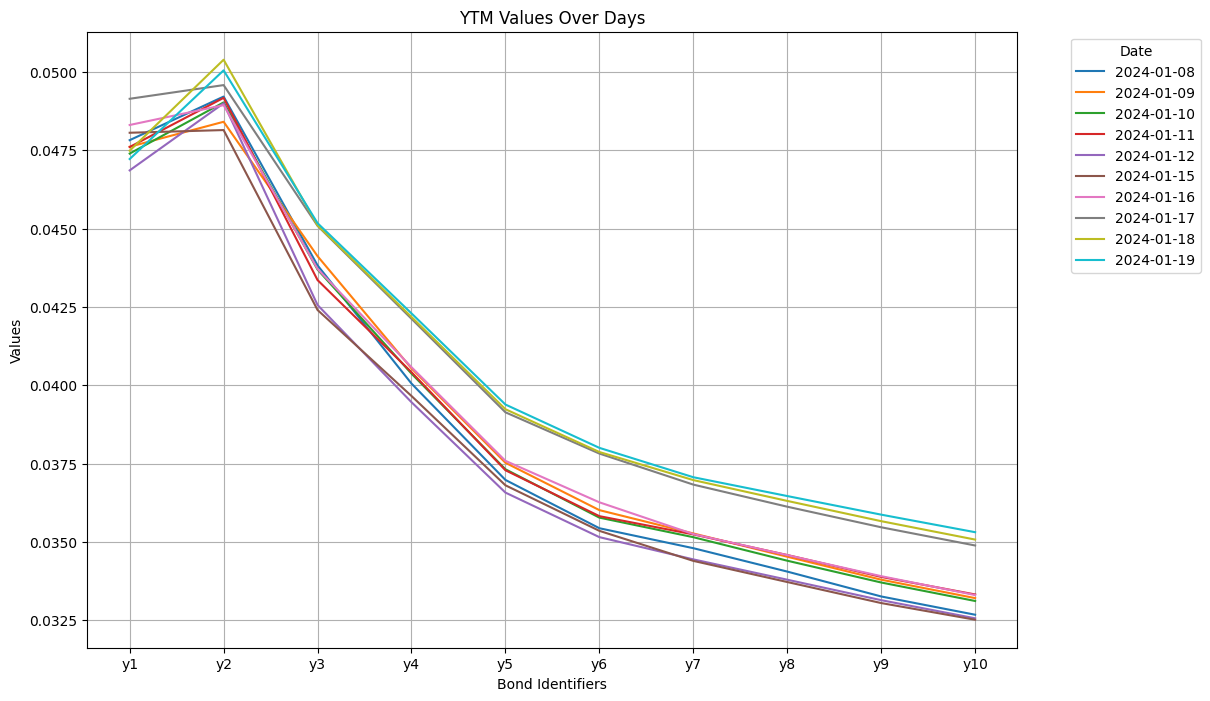

In [6]:
rows = []

# Loop through the dictionary and process each item
for key, value in YTM_dict.items():
    date, bond = key.rsplit('_', 1)
    bond_number = f'y{int(bond.replace("bond_", "")) + 1}'  # Convert bond_0 to y1, bond_1 to y2, etc.
    rows.append((date, bond_number, value))

# Create DataFrame
YTM_df = pd.DataFrame(rows, columns=['Date', 'Bond', 'Value'])

# Pivot the DataFrame
YTM_df_pivot = YTM_df.pivot(index='Date', columns='Bond', values='Value')

def sort_key(col_name):
    return int(col_name[1:])  # Sort based on the integer part of the column name

# Sort the columns using the custom sort function
columns_sorted = sorted(YTM_df_pivot.columns, key=sort_key)

# Reorder DataFrame columns
YTM_df_pivot = YTM_df_pivot[columns_sorted]

# Reset index to make 'Date' a column again
YTM_df_pivot.reset_index(inplace=True)
YTM_df_pivot['Date'] = YTM_df_pivot['Date'].str.extract(r'(\d{4}-\d{2}-\d{2})')

# Convert the 'Date' column to datetime format and then to date
YTM_df_pivot['Date'] = pd.to_datetime(YTM_df_pivot['Date']).dt.date
# Set the x-axis labels (y1, y2, ..., y10)
x_labels = sorted(YTM_df_pivot.columns[1:], key=lambda x: int(x[1:]))  # Excluding the 'Date' column

plt.figure(figsize=(12, 8))

# Plot each day as a separate line
for index, row in YTM_df_pivot.iterrows():
    plt.plot(x_labels, row[1:], label=row['Date'])  # Skip the 'Date' column for y values

plt.xlabel('Bond Identifiers')
plt.ylabel('Values')
plt.title('YTM Values Over Days')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.xticks(x_labels)
plt.grid(True)
plt.savefig('ytm_values_over_days.png')
plt.show()

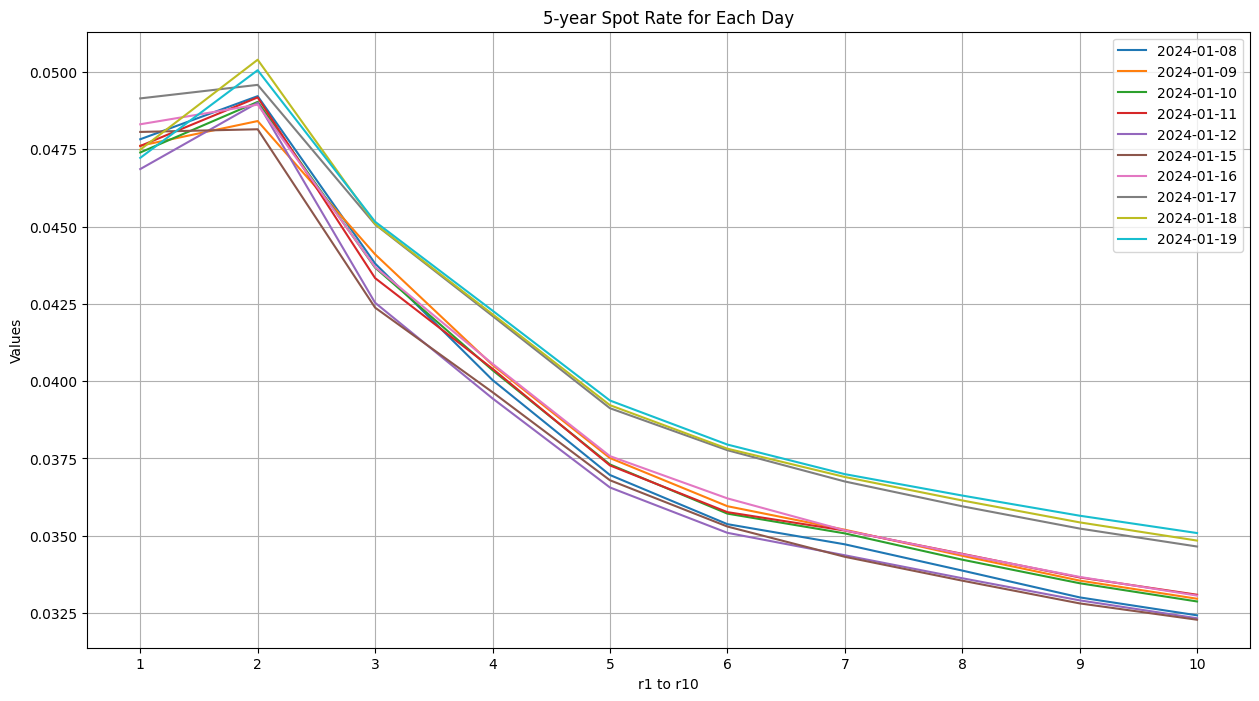

In [7]:
# Calculate 0.5-year, 1-year, ..., spot rate from Jan-08-2024 to Jan-09-2024

spot_dict = {}
for k in df['DATE'].unique():
    sub_df = df.loc[df['DATE'] == k]
    cashflow_days = [((maturity_date - sub_df['DATE'].iloc[0]).days/365) for maturity_date in df['Maturity Date'].unique()]
    Value = sub_df['Dirty Price'].to_numpy()
    matrix = sub_df.iloc[:, 7:17].to_numpy()
    discount_factor = np.linalg.solve(matrix, Value)
    YTM = [-np.log(j) / i if i != 0 else 0 for i, j in zip(cashflow_days, discount_factor)]  # Handle division by zero
    spot_dict[k] = YTM

# Convert the dictionary into a DataFrame
spot_df = pd.DataFrame.from_dict(spot_dict, orient='index')

# Name the columns as r1, r2, ..., r10
spot_df.columns = [f'r{i}' for i in range(1, 11)]

# Reset the index to make 'DATE' a column
spot_df.reset_index(inplace=True)
spot_df.rename(columns={'index': 'DATE'}, inplace=True)

# Sort the DataFrame by 'DATE'
spot_df.sort_values(by='DATE', inplace=True)
plt.figure(figsize=(15, 8))

# The x-axis values representing r1 to r10
r_values = range(1, 11)

# Plotting a line for each date
for index, row in spot_df.iterrows():
    plt.plot(r_values, row[1:], label=row['DATE'].strftime('%Y-%m-%d'))

plt.xlabel('r1 to r10')
plt.ylabel('Values')
plt.title('5-year Spot Rate for Each Day')
plt.savefig('spot_rates_values_over_days.png')
plt.xticks(r_values)
plt.legend()
plt.grid(True)
plt.show()

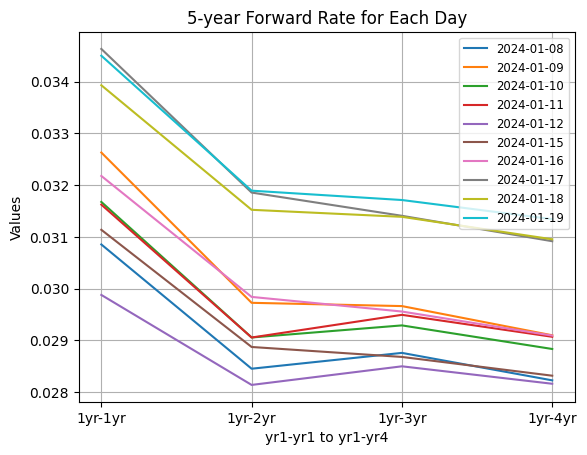

In [8]:
forward_dict = {}

for i in spot_df['DATE'].unique():
    row = sub_df[sub_df['DATE'] == k]
    r1 = spot_df[spot_df['DATE'] == i].iloc[0,2]
    r2 = spot_df[spot_df['DATE'] == i].iloc[0,4]
    r3 = spot_df[spot_df['DATE'] == i].iloc[0,6]
    r4 = spot_df[spot_df['DATE'] == i].iloc[0,8]
    r5 = spot_df[spot_df['DATE'] == i].iloc[0,10]

    f1 = (r2*2-r1*1)/(2-1)
    f2 = (r3*3 - r1*1)/(3-1)
    f3= (r4*4 - r1*1)/(4-1)
    f4 = (r5*5 - r1*1)/(5-1)
    forward = [f1, f2, f3, f4]
    forward_dict[i] = forward

forward_df = pd.DataFrame.from_dict(forward_dict, orient='index')
forward_df.columns = [f'1yr-{i}yr' for i in range(1, 5)]
forward_df.reset_index(inplace=True)
forward_df.rename(columns={'index': 'DATE'}, inplace=True)
r_values = [f'1yr-{i}yr' for i in range(1, 5)]

for index, row in forward_df.iterrows():
    plt.plot(r_values, row[1:], label=row['DATE'].strftime('%Y-%m-%d'))

plt.xlabel('yr1-yr1 to yr1-yr4')
plt.ylabel('Values')
plt.title('5-year Forward Rate for Each Day')
plt.xticks(r_values)
plt.legend(loc='upper right', frameon=True, fontsize='small')
plt.grid(True)
plt.savefig('5-year Forward Rate for Each Day')
plt.show()


In [9]:
forward_df

,DATE,1yr-1yr,1yr-2yr,1yr-3yr,1yr-4yr
0,2024-01-08,0.030855,0.028452,0.028758,0.028227
1,2024-01-09,0.032632,0.029726,0.029663,0.029099
2,2024-01-10,0.031677,0.029056,0.029290,0.028834
3,2024-01-11,0.031625,0.029056,0.029494,0.029069
4,2024-01-12,0.029879,0.028139,0.028499,0.028161
5,2024-01-15,0.031138,0.028872,0.028680,0.028317
6,2024-01-16,0.032179,0.029840,0.029558,0.029093
7,2024-01-17,0.034635,0.031858,0.031408,0.030917
8,2024-01-18,0.033933,0.031524,0.031389,0.030954
9,2024-01-19,0.034504,0.031894,0.031714,0.031344


In [18]:
YTM_df_pivot['Date'] = pd.to_datetime(YTM_df_pivot['Date'])

# Shift the DataFrame to get the previous day's prices
YTM_df_pivot_shifted = YTM_df_pivot.shift(1)

# Initialize a new DataFrame for log returns
log_returns_YTM = pd.DataFrame()

# Calculate log returns for each column y1 to y10
for column in ['y2', 'y4', 'y6', 'y8', 'y10']:
    log_returns_YTM[f'log_return_{column}'] = np.log(YTM_df_pivot[column] /YTM_df_pivot_shifted[column])

# Including the 'Date' for reference
log_returns_YTM = log_returns_YTM.dropna()
covariance_matrix = log_returns_YTM.cov()

# Calculate eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Output the results

covariance_matrix

,log_return_y2,log_return_y4,log_return_y6,log_return_y8,log_return_y10
log_return_y2,0.000185,0.000064,0.000056,0.000096,0.000090
log_return_y4,0.000064,0.000296,0.000306,0.000318,0.000325
log_return_y6,0.000056,0.000306,0.000323,0.000331,0.000338
log_return_y8,0.000096,0.000318,0.000331,0.000355,0.000363
log_return_y10,0.000090,0.000325,0.000338,0.000363,0.000372


In [17]:
forward_df['DATE'] = pd.to_datetime(forward_df['DATE'])
forward_df_shifted = forward_df.shift(1)

# Initialize a new DataFrame for log returns
log_returns_forward = pd.DataFrame()

# Calculate log returns for each column
for column in ['1yr-1yr', '1yr-2yr', '1yr-3yr', '1yr-4yr']:
    log_returns_forward[f'log_return_{column}'] = np.log(forward_df[column] / forward_df_shifted[column])

# Drop NaN values resulting from the shift
log_returns_forward = log_returns_forward.dropna()

# Calculate the covariance matrix
covariance_matrix = log_returns_forward.cov()

# Calculate eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Output the results
eigenvalues, eigenvectors


,log_return_1yr-1yr,log_return_1yr-2yr,log_return_1yr-3yr,log_return_1yr-4yr
log_return_1yr-1yr,0.001844,0.001363,0.001092,0.001030
log_return_1yr-2yr,0.001363,0.001037,0.000845,0.000797
log_return_1yr-3yr,0.001092,0.000845,0.000753,0.000717
log_return_1yr-4yr,0.001030,0.000797,0.000717,0.000685


In [12]:
YTM_df_pivot

Bond,Date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
0,2024-01-08,0.047823,0.049214,0.043826,0.040053,0.036977,0.035435,0.034798,0.034051,0.033257,0.032674
1,2024-01-09,0.047613,0.048410,0.044120,0.040538,0.037525,0.036013,0.035268,0.034525,0.033793,0.033204
2,2024-01-10,0.047395,0.049029,0.043693,0.040370,0.037317,0.035774,0.035149,0.034399,0.033703,0.033113
3,2024-01-11,0.047604,0.049174,0.043357,0.040416,0.037286,0.035821,0.035238,0.034580,0.033881,0.033321
4,2024-01-12,0.046858,0.049000,0.042561,0.039458,0.036573,0.035151,0.034440,0.033792,0.033139,0.032560
5,2024-01-15,0.048059,0.048145,0.042401,0.039657,0.036806,0.035352,0.034393,0.033718,0.033046,0.032514
6,2024-01-16,0.048307,0.048941,0.043713,0.040576,0.037586,0.036263,0.035249,0.034577,0.033905,0.033301
7,2024-01-17,0.049144,0.049581,0.045088,0.042122,0.039136,0.037819,0.036828,0.036122,0.035465,0.034884
8,2024-01-18,0.047487,0.050391,0.045103,0.042178,0.039234,0.037868,0.036972,0.036307,0.035660,0.035073
9,2024-01-19,0.047221,0.050052,0.045173,0.042293,0.039384,0.038001,0.037063,0.036462,0.035869,0.035308
